# [Multi-class classification with focal loss for imbalanced datasets](https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)

In this notebook, we predict whether transactions are fraud or not using the [PaySim dataset](https://www.kaggle.com/ntnu-testimon/paysim1) for fraud detection. The vast majority of transactions are not fraud, so the dataset has a severe class imbalance. We will use two neural network models, one using cross entropy loss and one using focal loss.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
np.random.seed(42)

In [2]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [3]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Prepare the data
Let's split the dataset into train, validation, and test sets, and normalize the features. We are using the first six columns of the data frame shown above as features, and the "isFraud" column as labels.

In [4]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [5]:
from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
y = keras.utils.to_categorical(y, num_classes=2)
X = feature_normalize(X.as_matrix())
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.5, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

## Baseline model

### Build the model
We make a simple dense neural network with four fully connected layers. The last layer uses a softmax activation to produce output scores for normal and fraud classes in the range [0, 1].

In [6]:
def get_classification_model():
    model = Sequential()
    input_dim = X_train.shape[1]
    nb_classes = y_train.shape[1]

    model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
    model.add(Dense(20, activation='relu', name='fc1'))
    model.add(Dense(10, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation='softmax', name='output'))
    return model

In [7]:
model = get_classification_model()
model.compile(loss='categorical_crossentropy',
          optimizer='nadam',
          metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [8]:
model.fit(X_train, y_train, epochs=3, batch_size=1000)

Epoch 1/3
3181310/3181310 [==============================] - 5s 1us/step - loss: 0.0132 - acc: 0.9986
Epoch 2/3
3181310/3181310 [==============================] - 4s 1us/step - loss: 0.0040 - acc: 0.9993
Epoch 3/3
3181310/3181310 [==============================] - 4s 1us/step - loss: 0.0036 - acc: 0.9993


After the model is trained, we run evaluation using the validation set.

In [9]:
eval_loss, eval_accuracy = model.evaluate(X_val, y_val, batch_size=1000)
print("Evaluation loss:", eval_loss)
print("Evaluation accuracy:", eval_accuracy)

1590655/1590655 [==============================] - 1s 1us/step
Evaluation loss: 0.0034516129638671894
Evaluation accuracy: 0.9993669342559043


Next, using our validation set, we will choose a threshold that will allow us to correctly classify at least 90% of fraud transactions.

In [10]:
y_pred_val = model.predict(X_val, batch_size=1000)

In [11]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

def choose_fraud_threshold(y_pred, y_truth, desired_pct_fraud_detected=90):
    y_truth_class = np.argmax(y_truth, axis=1)
    fraud_scores = y_pred_val[y_truth_class == 1][:, 1]
    normal_scores = y_pred_val[y_truth_class == 0][:, 1]
    threshold = np.percentile(fraud_scores, 100 - desired_pct_fraud_detected)

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.distplot(fraud_scores, bins=20, kde=False);
    ylim = plt.ylim()
    plt.plot(2 * [threshold], ylim)
    plt.xlabel("Fraud score")
    plt.ylabel("Counts")
    plt.title("Fraud Score Histogram\n(Actually Fraud)")

    plt.subplot(122)
    sns.distplot(normal_scores, bins=20, kde=False);
    ylim = plt.ylim()
    plt.plot(2 * [threshold], ylim)
    plt.xlabel("Fraud score")
    plt.ylabel("Counts")
    plt.title("Fraud Score Histogram\n(Actually Normal)")

    plt.tight_layout()
    plt.show()
    return threshold

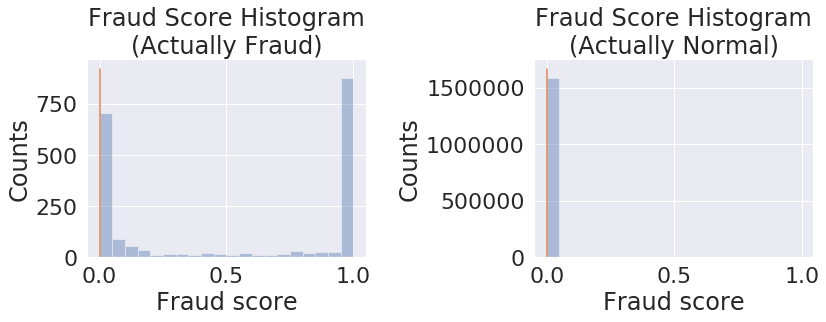

Threshold: 0.0007064975448884071


In [12]:
baseline_threshold = choose_fraud_threshold(y_pred_val, y_val)
print('Threshold:', baseline_threshold)

Notice that the scores are very concentrated near 0 and 1, so in order to make 90% of the true fraud transactions be classified as fraud, we have to set the threshold between normal and fraud very low.

### Predict normal vs. fraud on test set data
Now, let's analyze our model's performance on the test set data. We'll look at confusion matrix plots and calculate the F1 score.

In [13]:
# use trained model to predict normal vs. fraud on the test set
y_pred_test = model.predict(X_test, batch_size=1000)
np.set_printoptions(precision=3, suppress=True)
print(y_pred_test)

[[1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 ...
 [1.    0.   ]
 [0.997 0.003]
 [1.    0.   ]]


In [14]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

def plot_confusion_matrix(y_pred, y_truth, threshold):
    # convert predictions to labels
    y_truth_class = y_truth[:, 1] > threshold
    y_pred_class = y_pred[:, 1] > threshold
    # make confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_truth_class, y_pred_class)
    # normalize confusion matrix 
    n_truth = np.sum(confusion_matrix, axis=1, keepdims=True)
    confusion_matrix_normalized = confusion_matrix / n_truth

    # plot raw confusion matrix
    labels = ['Normal','Fraud'] 
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    # plot normalized confusion matrix
    plt.subplot(122)
    sns.heatmap(confusion_matrix_normalized, xticklabels=labels, yticklabels=labels, annot=True, fmt=".3f", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=2)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    return confusion_matrix

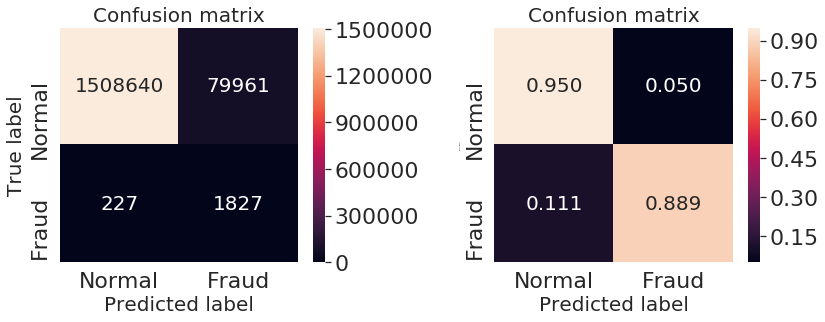

In [15]:
confusion_matrix = plot_confusion_matrix(y_pred_test, y_test, baseline_threshold)

In [16]:
def print_metrics(y_pred, y_truth, threshold):
    y_pred_class = y_pred[:, 1] > threshold
    y_truth_class = y_truth[:, 1] > threshold
    accuracy = np.sum(y_truth_class == y_pred_class) / len(y_truth_class)
    f1_score = metrics.f1_score(y_truth_class, y_pred_class)
    print("Test accuracy:", accuracy)
    print("F1 score:", f1_score)

    error_count = np.sum(y_pred_class != y_truth_class)
    print("Total misclassified samples:", error_count)

print_metrics(y_pred_test, y_test, baseline_threshold)

Test accuracy: 0.9495880627791696
F1 score: 0.043581975620810565
Total misclassified samples: 80188


## Focal Loss Model

### Build the model
Now, we will build a neural network model that is the same as before except that it uses focal loss instead of the standard cross-entropy loss. Note that focal loss includes two parameters, gamma and alpha. In the original focal loss paper, [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002), the authors selected gamma=2 and alpha=0.25 and showed that performance was not too sensitive to the exact values. However, you may get better results by tuning these parameters.

In [17]:
def focal_loss(gamma=2., alpha=0.25):
    """Return focal loss function for two-class classification.

    :param float gamma: optional value for gamma (default = 2.0)
    :param float alpha: optional value for alpha (default = 0.25)

    :return: focal loss function
        """

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Calculate focal loss for two-class classification.

        FL(p_t) = -alpha(1-p_t)^{gamma} * log(p_t)
        Reference: Focal Loss for Dense Object Detection
            https://arxiv.org/abs/1708.02002
            
        Notes: y_pred values are after softmax activation
            the second column of y_true and y_pred should be the rare class

        :param tensor y_true: ground truth labels, shape of [batch_size, 2]
        :param tensor y_pred: model's output, shape of [batch_size, 2]
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        # alpha is the weight of the rare class
        alphas = tf.constant([1 - alpha, alpha], dtype=tf.float32)
        focal_loss = -alphas * tf.pow(1. - y_pred, gamma) * tf.log(y_pred + epsilon) * y_true
        reduced_fl = tf.reduce_max(focal_loss, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [18]:
model = get_classification_model()
model.compile(loss=focal_loss(gamma=2.5, alpha=0.4),
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [19]:
model.fit(X_train, y_train, epochs=3, batch_size=1000)

Epoch 1/3
3181310/3181310 [==============================] - 5s 2us/step - loss: 8.2059e-04 - acc: 0.9991
Epoch 2/3
3181310/3181310 [==============================] - 5s 1us/step - loss: 4.1229e-04 - acc: 0.9993
Epoch 3/3
3181310/3181310 [==============================] - 4s 1us/step - loss: 3.6557e-04 - acc: 0.9993


In [20]:
eval_loss, eval_accuracy = model.evaluate(X_val, y_val, batch_size=1000)
print("Evaluation loss:", eval_loss)
print("Evaluation accuracy:", eval_accuracy)

1590655/1590655 [==============================] - 1s 1us/step
Evaluation loss: 0.00031184066983895234
Evaluation accuracy: 0.9993757354295144


In [21]:
y_val_labels = np.argmax(y_val, axis=1)
y_pred_val = model.predict(X_val, batch_size=1000)

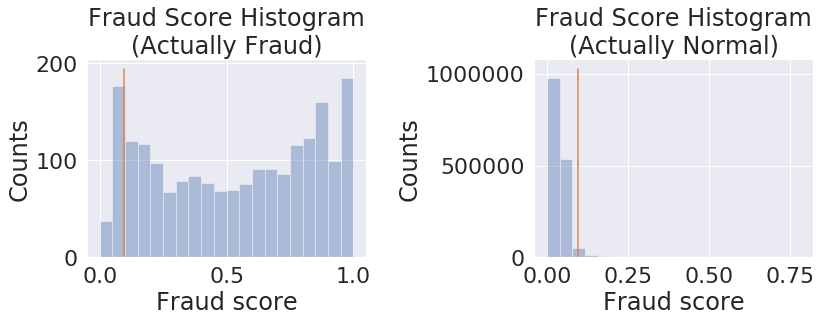

Threshold: 0.09640780836343765


In [22]:
focal_loss_threshold = choose_fraud_threshold(y_pred_val, y_val)
print("Threshold:", focal_loss_threshold)

The focal loss model's score distribution is much less extreme compared to the baseline model, so the threshold to classify 90% of the fraud transactions as fraud is a bit higher.

### Predict normal vs. fraud on test set data
Now, let's analyze our model's performance on the test set data. We'll look at confusion matrix plots and calculate the F1 score.

In [23]:
# use trained model to predict normal vs. fraud on the test set
y_pred_test = model.predict(X_test, batch_size=1000)
np.set_printoptions(precision=3, suppress=True)
print(y_pred_test)

[[0.954 0.046]
 [1.    0.   ]
 [0.99  0.01 ]
 ...
 [0.939 0.061]
 [0.87  0.13 ]
 [0.93  0.07 ]]


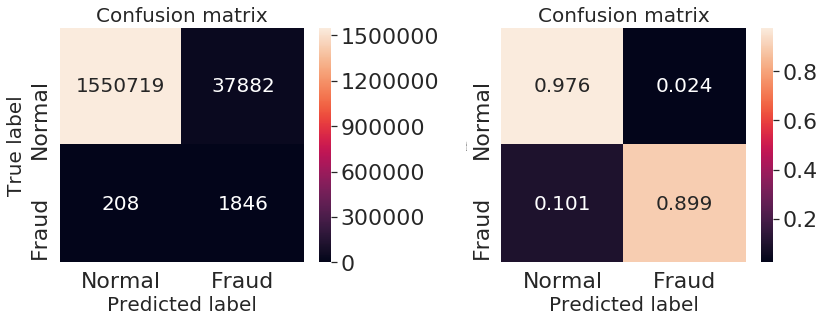

In [24]:
confusion_matrix = plot_confusion_matrix(y_pred_test, y_test, focal_loss_threshold)

In [26]:
print_metrics(y_pred_test, y_test, focal_loss_threshold)

Test accuracy: 0.97605388974982
F1 score: 0.08836341008089608
Total misclassified samples: 38090
